# Défi EGC 2024

In [1]:
%load_ext autoreload

### import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_frame_generator import generate_external_time_series,generate_global_time_series

### Get external time series

In [3]:
external_df = generate_external_time_series("timeseries/external.csv")

### Displaying HashRate and Bitcoin price

<Axes: xlabel='date'>

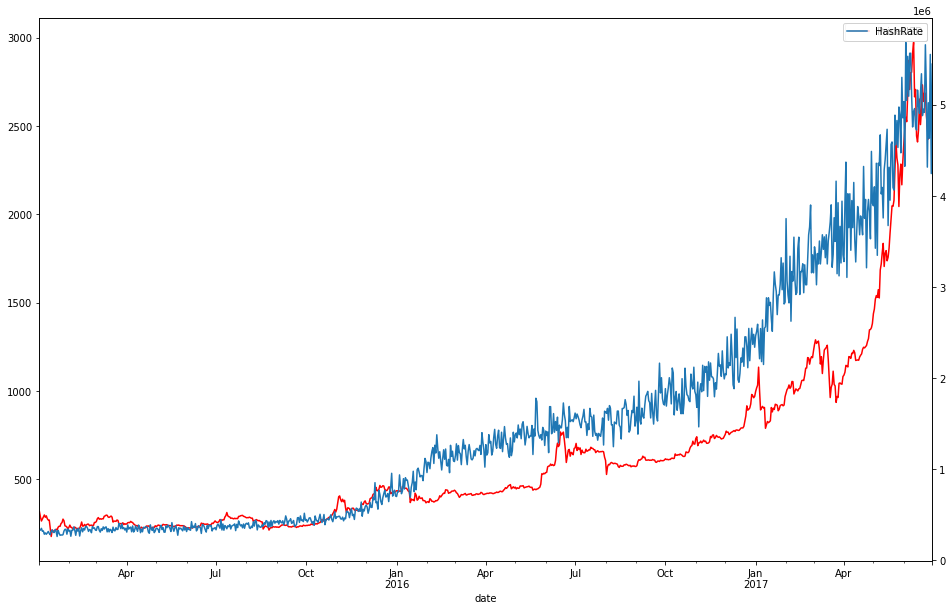

In [4]:
fig, ax1 = plt.subplots( figsize=(16, 10))
ax2 = ax1.twinx()
external_df.plot(x='date',y='PriceUSD',ax=ax1, color='red', legend='PriceUSD')
external_df.plot(x='date',y='HashRate',ax=ax2)

In [5]:
global_time_series = generate_global_time_series("timeseries/global.csv")
global_time_series

,date,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,nb_transactions,nb_payments,mean_nb_inputs,mean_nb_outputs,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self
0,2015-01-01,801373971,45473028339385,45058028339385,13609.829337,4.284054e+06,0.799999,58882,161194,2.595241,2.737577,166,415801373971,415000000000,2757774885900,45473028339385,42715253453485
1,2015-01-02,1159934218,73370568521080,72955568521080,14978.682808,4.732406e+06,0.778933,77439,257633,2.715557,3.326915,166,416159934218,415000000000,4316724676318,73370568521080,69053843844762
2,2015-01-03,1196476043,82635189454578,82220189454578,14304.385766,4.086009e+06,0.797419,83644,295618,2.781885,3.534240,166,416196476043,415000000000,5584584356557,82635189454578,77050605098021
3,2015-01-04,2159195328,115159442449532,114726942449532,25138.199015,6.619757e+06,0.899054,85893,280288,2.770133,3.263223,173,434659195328,432500000000,6554587956125,115159442449532,108604854493407
4,2015-01-05,1608443040,112439228285641,112051728285641,16955.609622,4.662858e+06,0.898594,94862,286552,2.954471,3.020725,155,389108443040,387500000000,5063695492444,112439228285641,107375532793197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2017-06-26,35993152232,375012739382430,374842739382430,145080.443192,3.520181e+08,2.771988,248091,626222,2.565329,2.524163,136,205993152232,170000000000,14151200557043,375012739382430,360861538825387
908,2017-06-27,38384859820,287624055555912,287452805555912,142346.452989,3.601857e+08,3.044288,269658,747924,2.314862,2.773602,137,209634859820,171250000000,19821969138631,287624055555912,267802086417281
909,2017-06-28,38663204682,282904720130478,282717220130478,140744.451983,3.606988e+08,2.884102,274705,686018,2.471178,2.497290,150,226163204682,187500000000,10958737629631,282904720130478,271945982500847
910,2017-06-29,33153365173,317698686929569,317543686929569,144453.442667,3.669758e+08,2.760877,229509,570680,2.451838,2.486526,124,188153365173,155000000000,16909883109542,317698686929569,300788803820027


In [6]:
column_count = len(global_time_series.columns[1:])

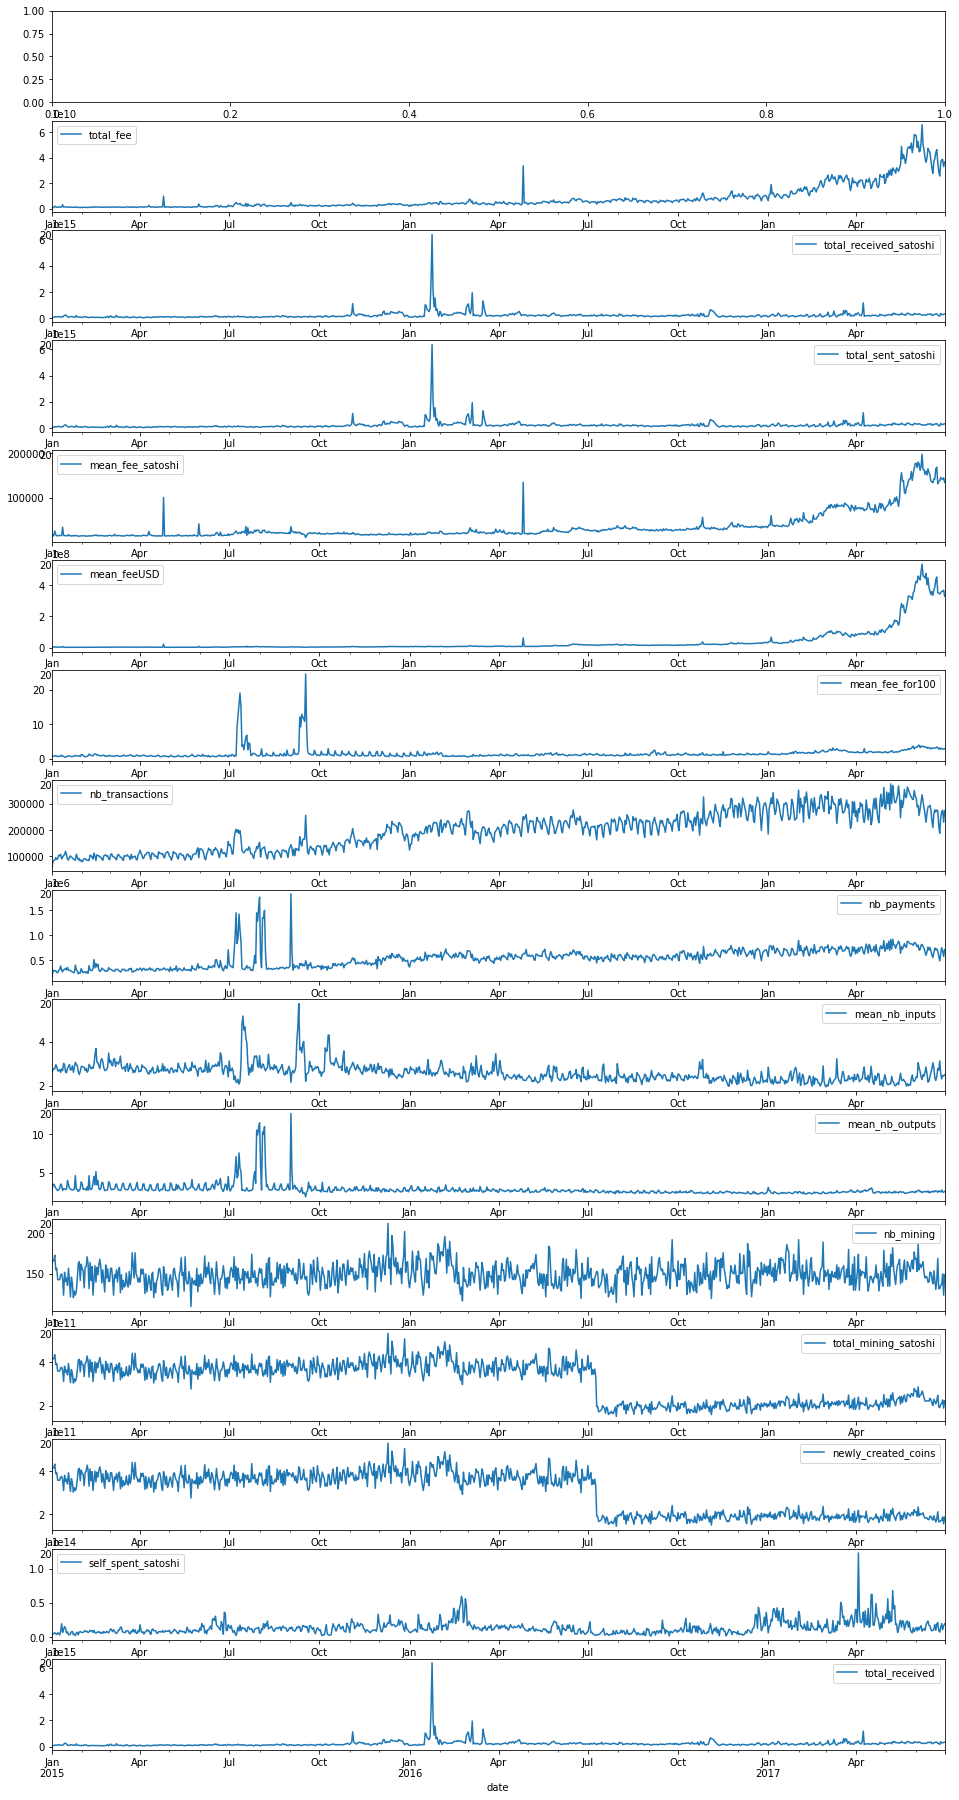

In [7]:
fig, axes = plt.subplots(nrows=column_count, ncols=1, figsize=(16, 32))
for i in range(1,column_count):
    key = global_time_series.columns[i]
    global_time_series.plot(x='date', y=key, ax=axes[i])


In [11]:
network_df  = pd.read_csv("networks/2015-1-5.csv")
network_df
network_df.groupby(by="Source")["value"].sum().sort_values()

Source
637914                               7219
1731122                              9000
69146577                            10533
199545                              12796
69406832                            17249
                               ...       
70325236                    1406472183932
Huobi.com                   1553200616162
157228                      1761198520000
GHash.io                    2703962946375
ePay.info_CoinJoinMess    229626381909370
Name: value, Length: 779, dtype: int64

In [13]:


# créer un DataFrame avec des dates sous forme de chaînes de caractères
global_time_series = pd.DataFrame({'date': ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01']})

# convertir la colonne 'date' en objet datetime
global_time_series['date'] = pd.to_datetime(global_time_series['date'])

# afficher le DataFrame avec la colonne 'date' convertie en objet datetime



        date
0 2022-01-01
1 2022-02-01
2 2022-03-01
3 2022-04-01


date   2022-01-01
Name: 0, dtype: datetime64[ns]